In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt

from textblob import TextBlob
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

In [3]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df_positive = df[df["sentiment"] == "positive"].sample(2500)
df_negative = df[df["sentiment"] == "negative"].sample(2500)

In [7]:
df = pd.concat([df_positive,df_negative],ignore_index=True).sample(5000)

In [8]:
df.head()

,review,sentiment
2051,As with a bunch of guys at school we must give...,positive
3788,Bloodsuckers has the potential to be a somewha...,negative
3488,If i could have rated this movie by 0 i would ...,negative
2597,I can't help but be completely annoyed by this...,negative
1208,Odd but wonderfully original movie. Genuinely ...,positive


In [9]:
df.shape

(5000, 2)

### Data Cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2051 to 4580
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])

In [13]:
df.head()

,review,sentiment
2051,As with a bunch of guys at school we must give...,1
3788,Bloodsuckers has the potential to be a somewha...,0
3488,If i could have rated this movie by 0 i would ...,0
2597,I can't help but be completely annoyed by this...,0
1208,Odd but wonderfully original movie. Genuinely ...,1


In [14]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [15]:
df.duplicated().sum()

2

In [16]:
df = df.drop_duplicates(keep="first")

In [17]:
df.duplicated().sum()

0

In [18]:
df.shape

(4998, 2)

# Data Preprocessing

### 1. Lowercase conversion

In [19]:
df["review"] = df["review"].apply(lambda x:x.lower())

In [20]:
df.head()

,review,sentiment
2051,as with a bunch of guys at school we must give...,1
3788,bloodsuckers has the potential to be a somewha...,0
3488,if i could have rated this movie by 0 i would ...,0
2597,i can't help but be completely annoyed by this...,0
1208,odd but wonderfully original movie. genuinely ...,1


### 2. Contraction to Expansion

In [21]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [22]:
def contr_to_exp(x):
    
    if type(x) is str:
        for key in contractions.keys():
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

In [23]:
df["review"] = df["review"].apply(contr_to_exp)

In [24]:
df.head()

,review,sentiment
2051,as with a bunch of guys at school we must give...,1
3788,bloodsuckers has the potential to be a somewha...,0
3488,if i could have rated this movie by 0 i would ...,0
2597,i cannot help but be completely annoyed by thi...,0
1208,odd but wonderfully original movie. genuinely ...,1


### Remove URL

In [25]:
import re

In [26]:
df["urls"] = df["review"].apply(lambda x: re.findall(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', x))

In [27]:
df["urls_count"] = df["urls"].apply(lambda x: len(x))

In [28]:
df[df["urls_count"]>0]

,review,sentiment,urls,urls_count
2978,years ago a movie going friend and i went to s...,0,[http://thevillagevideot.blogspot.com],1
4654,"i do not normally write reviews, but for this ...",0,[http://www.weatherpaparazzi.com],1
2651,in trying to keep up with the hipness of youth...,0,[http://barbra-archives.com],1
4450,this film is not deserved of the next few minu...,0,[http://www.imdb.com],1
4313,check out the two octogenarians who review lea...,0,[http://www.youtube.com],1
1333,there is a complete copy now available at the ...,1,[http://www.archive.org],1
2549,did uwe boll seriously just rip off the basic ...,0,[http://zuucka.deviantart.com],1
4599,ok i went to this website before i watched thi...,0,[http://imdb.com],1
2855,"after having watched darwin's nightmare, one m...",0,"[http://www.taz.de, http://www.taz.de]",2
25,felix unger (jack lemmon) has just been dumped...,1,[http://blog.myspace.com],1


In [29]:
df["review"] = df["review"].apply(lambda x:re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', x))

In [30]:
df[df["urls_count"]>0]

,review,sentiment,urls,urls_count
2978,years ago a movie going friend and i went to s...,0,[http://thevillagevideot.blogspot.com],1
4654,"i do not normally write reviews, but for this ...",0,[http://www.weatherpaparazzi.com],1
2651,in trying to keep up with the hipness of youth...,0,[http://barbra-archives.com],1
4450,this film is not deserved of the next few minu...,0,[http://www.imdb.com],1
4313,check out the two octogenarians who review lea...,0,[http://www.youtube.com],1
1333,there is a complete copy now available at the ...,1,[http://www.archive.org],1
2549,did uwe boll seriously just rip off the basic ...,0,[http://zuucka.deviantart.com],1
4599,ok i went to this website before i watched thi...,0,[http://imdb.com],1
2855,"after having watched darwin's nightmare, one m...",0,"[http://www.taz.de, http://www.taz.de]",2
25,felix unger (jack lemmon) has just been dumped...,1,[http://blog.myspace.com],1


### Removal of HTML tags

In [31]:
def remove_html_tags(html_string):
    # Regular expression pattern to match HTML tags
    pattern = re.compile(r'<.*?>')

    # Remove HTML tags using the pattern
    text = re.sub(pattern, '', html_string)

    return text

In [32]:
df["review"] = df["review"].apply(remove_html_tags)

In [33]:
df.head()

,review,sentiment,urls,urls_count
2051,as with a bunch of guys at school we must give...,1,[],0
3788,bloodsuckers has the potential to be a somewha...,0,[],0
3488,if i could have rated this movie by 0 i would ...,0,[],0
2597,i cannot help but be completely annoyed by thi...,0,[],0
1208,odd but wonderfully original movie. genuinely ...,1,[],0


### Removal of Email

In [34]:
df["emails"] = df["review"].apply(lambda x: re.findall(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', x))

In [35]:
df.head()

,review,sentiment,urls,urls_count,emails
2051,as with a bunch of guys at school we must give...,1,[],0,[]
3788,bloodsuckers has the potential to be a somewha...,0,[],0,[]
3488,if i could have rated this movie by 0 i would ...,0,[],0,[]
2597,i cannot help but be completely annoyed by thi...,0,[],0,[]
1208,odd but wonderfully original movie. genuinely ...,1,[],0,[]


In [36]:
df["email_count"] = df["emails"].apply(lambda x:len(x))

In [37]:
df[df["email_count"]>0]

,review,sentiment,urls,urls_count,emails,email_count
1566,i love this movie. and disney channel is ridic...,1,[],0,[cristin6891@aim.com],1
332,"a major moneymaker for rko radio, bombardier s...",1,[],0,[iamaseal2@yahoo.com],1
832,i could never remember the name of this show. ...,1,[],0,[kywildflower16@hotmail.com],1
2008,i watched this episode a lot of times because ...,1,[],0,[angelpuss924@yahoo.com],1
456,i saw this movie once as a kid on the late-lat...,1,[],0,[cartwrightbride@yahoo.com],1


In [38]:
df["review"] = df["review"].apply(lambda x: re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', "",x))

### Removal of Multiple Spaces

In [39]:
df["review"] = df["review"].apply(lambda x: " ".join(x.split()))

In [40]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count
2051,as with a bunch of guys at school we must give...,1,[],0,[],0
3788,bloodsuckers has the potential to be a somewha...,0,[],0,[],0
3488,if i could have rated this movie by 0 i would ...,0,[],0,[],0
2597,i cannot help but be completely annoyed by thi...,0,[],0,[],0
1208,odd but wonderfully original movie. genuinely ...,1,[],0,[],0


### Common Word Removal

In [41]:
text = " ".join(df["review"])

In [42]:
text = text.split()

In [43]:
freq_comm = pd.Series(text).value_counts()

In [44]:
freq_comm

the         64181
and         32106
a           32038
of          29064
is          26564
            ...  
ringling        1
barnum          1
smile.i         1
makeup.-        1
heck.           1
Name: count, Length: 94068, dtype: int64

In [45]:
freq_comm[:20]

the     64181
and     32106
a       32038
of      29064
is      26564
to      26562
in      18159
it      16229
i       16186
this    14083
that    13626
not     10948
was      9907
as       9012
with     8721
for      8440
but      7811
have     6382
on       6370
are      6233
Name: count, dtype: int64

### Rare Occuring Words

In [46]:
rare_20 = freq_comm.sort_values(ascending=True)[:20]

In [47]:
rare_20

till,                1
slush                1
desica               1
ball.by              1
curmudgeon,          1
films).              1
effects--after       1
make--this           1
ensemble-type        1
milan,               1
neo-realistic        1
'zero'               1
duration.finally,    1
favor;               1
advertisements,      1
confine              1
trice.to             1
(princess            1
'baddies'            1
worth.it             1
Name: count, dtype: int64

### Removing Punctuations

In [48]:
def remove_punctuation(text):
    # Remove punctuation using string.punctuation
    text_without_punct = text.translate(str.maketrans('', '', string.punctuation))
    # Alternatively, remove punctuation using regular expressions
    # pattern = re.compile(r'[^\w\s]')
    # text_without_punct = re.sub(pattern, '', text)
    return text_without_punct

In [49]:
df["review"] = df["review"].apply(remove_punctuation)

In [50]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count
2051,as with a bunch of guys at school we must give...,1,[],0,[],0
3788,bloodsuckers has the potential to be a somewha...,0,[],0,[],0
3488,if i could have rated this movie by 0 i would ...,0,[],0,[],0
2597,i cannot help but be completely annoyed by thi...,0,[],0,[],0
1208,odd but wonderfully original movie genuinely f...,1,[],0,[],0


In [51]:
df["polarity"] = df["review"].apply(lambda x: TextBlob(x).sentiment.polarity)

### Removing Stopwords

In [52]:
def remove_stopwords(text):

    word_tokenized_text = word_tokenize(text)

    temp = [word for word in word_tokenized_text if word not in stopwords.words("english")]

    return " ".join(temp)

In [53]:
%%time
df["review"] = df["review"].apply(remove_stopwords)

CPU times: user 1min 34s, sys: 18.6 s, total: 1min 52s
Wall time: 1min 52s


### Applying Stemming

In [54]:
ps = PorterStemmer()

In [55]:
def stemming(text):

    word_tokenized_text = word_tokenize(text)

    temp = [ps.stem(word) for word in word_tokenized_text]

    return " ".join(temp)

In [56]:
%%time
df["review"] = df["review"].apply(stemming)

CPU times: user 13.8 s, sys: 14.7 ms, total: 13.8 s
Wall time: 13.8 s


### Feature Engineering

In [57]:
df["num_chars"] = df["review"].apply(lambda x:len(x))

In [58]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count,polarity,num_chars
2051,bunch guy school must give thumb even grim rip...,1,[],0,[],0,0.062500,400
3788,bloodsuck potenti somewhat decent movi concept...,0,[],0,[],0,0.046743,1453
3488,could rate movi 0 would see ppl imdb say funni...,0,[],0,[],0,0.045833,394
2597,help complet annoy sitcom like even bother tri...,0,[],0,[],0,0.023264,700
1208,odd wonder origin movi genuin frighten creepi ...,1,[],0,[],0,0.121733,536


In [59]:
df["num_words"] = df["review"].apply(lambda x: len(word_tokenize(x)))

In [60]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count,polarity,num_chars,num_words
2051,bunch guy school must give thumb even grim rip...,1,[],0,[],0,0.062500,400,70
3788,bloodsuck potenti somewhat decent movi concept...,0,[],0,[],0,0.046743,1453,229
3488,could rate movi 0 would see ppl imdb say funni...,0,[],0,[],0,0.045833,394,75
2597,help complet annoy sitcom like even bother tri...,0,[],0,[],0,0.023264,700,113
1208,odd wonder origin movi genuin frighten creepi ...,1,[],0,[],0,0.121733,536,86


In [61]:
df["num_sentences"] = df["review"].apply(lambda x: len(sent_tokenize(x)))

In [62]:
df.head()

,review,sentiment,urls,urls_count,emails,email_count,polarity,num_chars,num_words,num_sentences
2051,bunch guy school must give thumb even grim rip...,1,[],0,[],0,0.062500,400,70,1
3788,bloodsuck potenti somewhat decent movi concept...,0,[],0,[],0,0.046743,1453,229,1
3488,could rate movi 0 would see ppl imdb say funni...,0,[],0,[],0,0.045833,394,75,1
2597,help complet annoy sitcom like even bother tri...,0,[],0,[],0,0.023264,700,113,1
1208,odd wonder origin movi genuin frighten creepi ...,1,[],0,[],0,0.121733,536,86,1


### EDA

<Axes: xlabel='num_chars', ylabel='Count'>

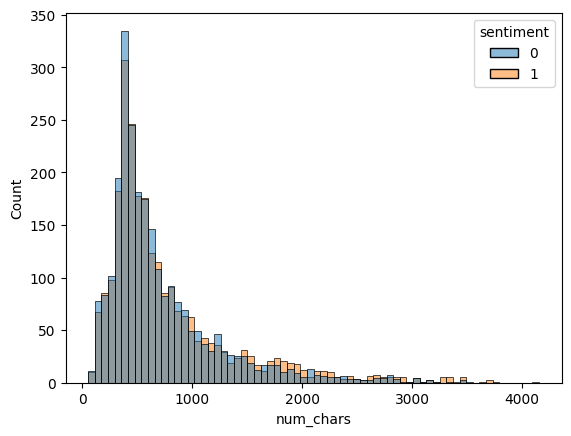

In [63]:
sns.histplot(x="num_chars",data=df,hue="sentiment")

<Axes: xlabel='num_words', ylabel='Count'>

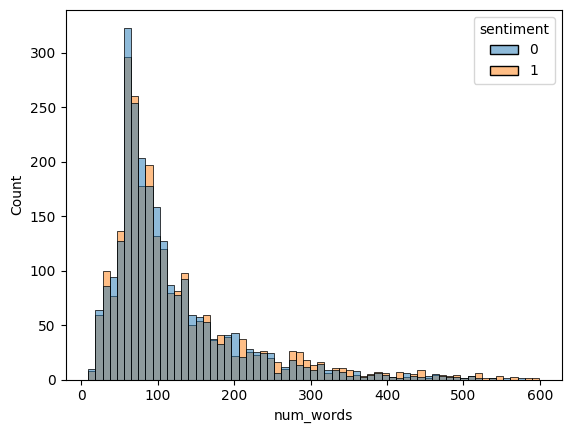

In [64]:
sns.histplot(x="num_words",data=df,hue="sentiment")

Text(0.5, 1.0, 'Sentiment polarity Distribution')

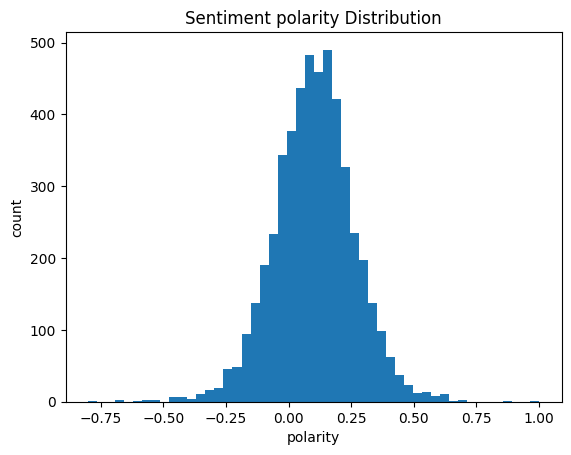

In [65]:
df["polarity"].plot(kind="hist",bins=50)
plt.xlabel("polarity")
plt.ylabel("count")
plt.title("Sentiment polarity Distribution")

### Text Vectorization

In [112]:
X = df["review"]
y = df["sentiment"]

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [114]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [115]:
clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.626
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       500
           1       0.62      0.66      0.64       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



In [116]:
clf = BernoulliNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.824
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       500
           1       0.87      0.76      0.81       500

    accuracy                           0.82      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000



In [117]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.843
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       500
           1       0.86      0.82      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [118]:
text = remove_punctuation("It was a very Amazing movie. I went and watched it twice")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

array([1])

In [119]:
text = remove_punctuation("One of the bad movies. Climax was the worst one")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

array([0])

In [120]:
text = remove_punctuation("Climax was the worst one")
text = remove_stopwords(text)
text = stemming(text)
text = tfidf.transform([text]).toarray()
clf.predict(text)

array([0])